# Return Analysis

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
# 初始化离线模式
py.init_notebook_mode(connected=True)

In [2]:
tag = 'EURUSD'
# 定义要计算的时间间隔
time_intervals = [1, 5, 10, 60, 300, 600, 1800, 3600]

In [3]:
# 读取CSV文件
news_scores = pd.read_csv(f'result/{tag}_news_scores.csv')
price_data = pd.read_csv(f'price/{tag}.csv')

# 将Created Date转换为datetime类型，并去除时区信息
news_scores['Created Date'] = pd.to_datetime(news_scores['Created Date']).dt.tz_localize(None)
news_scores['Created Date'] = news_scores['Created Date'].dt.floor('min')  # 将时间向下取整到分钟

news_scores = news_scores.rename(columns={'Created Date': 'createDate'})

# 将datetime转换为datetime类型
price_data['datetime'] = pd.to_datetime(price_data['datetime'])
# 将price_data设置为以datetime为索引
price_data.set_index('datetime', inplace=True)


# Convert price columns to float
price_data['close'] = pd.to_numeric(price_data['close'], errors='coerce')
price_data['open'] = pd.to_numeric(price_data['open'], errors='coerce')
price_data['high'] = pd.to_numeric(price_data['high'], errors='coerce')
price_data['low'] = pd.to_numeric(price_data['low'], errors='coerce')



# 定义计算收益的函数
def calculate_returns(row, n, price_data):
    current_time = row['createDate']
    future_time = current_time + pd.Timedelta(minutes=n)
    
    try:
        current_close = price_data.loc[current_time, 'close']
        current_open = price_data.loc[current_time, 'open']
        future_close = price_data.loc[future_time, 'close']
        future_open = price_data.loc[future_time, 'open']
        
        r_close = (future_close - current_close) / current_close
        r_open = (future_open - current_open) / current_open
        
        return pd.Series({'r_{}'.format(n): r_close, 'r_open_{}'.format(n): r_open})
    except KeyError:
        return pd.Series({'r_{}'.format(n): np.nan, 'r_open_{}'.format(n): np.nan})

# 计算不同时间间隔的收益
for n in time_intervals:
    news_scores = news_scores.join(news_scores.apply(lambda row: calculate_returns(row, n, price_data), axis=1))

# 保存结果到新的CSV文件
news_scores.to_csv(f'result/{tag}_scores_returns.csv', index=False)

In [4]:
df = news_scores.dropna().copy()

close_list = [f'r_{n}' for n in time_intervals]
open_list = [f'r_open_{n}' for n in time_intervals]
columns_to_process = close_list + open_list

for col in columns_to_process:
    new_col = f"{col}_v"
    
    # 创建新列，初始值与原列相同
    df[new_col] = df[col]* -1
    
    # 对 Vader_sentiment_title 小于 0 的行，新列的值乘以 -1
    mask = df['Vader_sentiment_title'] < 0
    df.loc[mask, new_col] = df.loc[mask, col]

# 验证结果
df.head()

,createDate,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_EUR,Vader_sentiment_title,r_1,r_open_1,r_5,r_open_5,...,r_1800_v,r_3600_v,r_open_1_v,r_open_5_v,r_open_10_v,r_open_60_v,r_open_300_v,r_open_600_v,r_open_1800_v,r_open_3600_v
1,2024-04-29 06:13:00,EUR/USD Price Analysis: Keeps steady above 1.0...,EURUSD,0.999999,0.000000,0.0000,0.0,0.000000,0.000093,0.000093,...,-0.000280,0.002991,-0.000000,-0.000093,-0.000187,-0.000280,-0.001682,-0.002056,-0.000280,0.002991
2,2024-04-29 14:33:00,"EUR/USD retreats ahead of Eurozone, US data-pa...",EURUSD,0.000000,-0.694304,0.0000,0.0,-0.000187,0.000000,0.000000,...,0.002052,0.002052,0.000187,-0.000000,0.000093,0.000280,0.000187,-0.000373,0.002052,0.003265
3,2024-04-29 22:28:00,EUR/USD finds support near 1.0720 after slow g...,EURUSD,0.000000,0.000000,0.4019,0.0,0.000000,0.000000,-0.000093,...,0.003176,-0.001308,-0.000000,0.000093,-0.000093,-0.001121,-0.001401,-0.001121,0.003176,-0.001308
4,2024-04-30 04:31:00,EUR/USD Price Analysis: Manages to hold above ...,EURUSD,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,...,0.005969,0.001492,-0.000000,-0.000000,-0.000000,-0.000000,0.000653,0.002611,0.005876,0.001492
5,2024-04-30 14:32:00,"EUR/USD drops on US Dollar's recovery, steady ...",EURUSD,0.993590,-0.972448,0.0000,0.0,0.000000,0.000000,-0.000094,...,0.001029,-0.002806,-0.000000,0.000094,-0.000187,-0.001309,-0.002525,0.001216,0.001309,-0.002806


In [5]:
import pandas as pd
from datetime import timedelta

def calculate_cumulative_returns(df, n):
    df = df.sort_values('createDate')
    df[f'Cum_r_{n}'] = 0.0
    last_trade_date = df.iloc[0]['createDate']
    cum_return = 1.0

    for i, row in df.iterrows():
        if i == 0 or (row['createDate'] - last_trade_date) >= timedelta(minutes=n):
            cum_return *= (1 + row[f'r_{n}_v'])
            last_trade_date = row['createDate']
        
        df.at[i, f'Cum_r_{n}'] = cum_return - 1

    return df

def calculate_cumulative_open_returns(df, n):
    df = df.sort_values('createDate')
    df[f'Cum_r_open_{n}'] = 0.0
    last_trade_date = df.iloc[0]['createDate']
    cum_return = 1.0

    for i, row in df.iterrows():
        if i == 0 or (row['createDate'] - last_trade_date) >= timedelta(minutes=n):
            cum_return *= (1 + row[f'r_open_{n}_v'])
            last_trade_date = row['createDate']
        
        df.at[i, f'Cum_r_open_{n}'] = cum_return - 1

    return df

# 使用示例
# df = pd.read_csv('your_data.csv', parse_dates=['createDate'])
# n = 5  # 假设n为5分钟

for n in time_intervals:
    df = calculate_cumulative_returns(df, n)
    df = calculate_cumulative_open_returns(df, n)
df.head()

,createDate,Title,Tag,FinBERT_sentiment_title,ABSA_Bert_sentiment_title_EUR,Vader_sentiment_title,r_1,r_open_1,r_5,r_open_5,...,Cum_r_60,Cum_r_open_60,Cum_r_300,Cum_r_open_300,Cum_r_600,Cum_r_open_600,Cum_r_1800,Cum_r_open_1800,Cum_r_3600,Cum_r_open_3600
1,2024-04-29 06:13:00,EUR/USD Price Analysis: Keeps steady above 1.0...,EURUSD,0.999999,0.000000,0.0000,0.0,0.000000,0.000093,0.000093,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2024-04-29 14:33:00,"EUR/USD retreats ahead of Eurozone, US data-pa...",EURUSD,0.000000,-0.694304,0.0000,0.0,-0.000187,0.000000,0.000000,...,-0.000093,0.000280,0.000187,0.000187,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,2024-04-29 22:28:00,EUR/USD finds support near 1.0720 after slow g...,EURUSD,0.000000,0.000000,0.4019,0.0,0.000000,0.000000,-0.000093,...,-0.001308,-0.000842,-0.001215,-0.001215,-0.001121,-0.001121,0.000000,0.000000,0.0,0.0
4,2024-04-30 04:31:00,EUR/USD Price Analysis: Manages to hold above ...,EURUSD,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,...,-0.001308,-0.000842,-0.000656,-0.000563,-0.001121,-0.001121,0.000000,0.000000,0.0,0.0
5,2024-04-30 14:32:00,"EUR/USD drops on US Dollar's recovery, steady ...",EURUSD,0.993590,-0.972448,0.0000,0.0,0.000000,0.000000,-0.000094,...,-0.002709,-0.002150,-0.003460,-0.003087,0.000187,0.000093,0.001029,0.001309,0.0,0.0


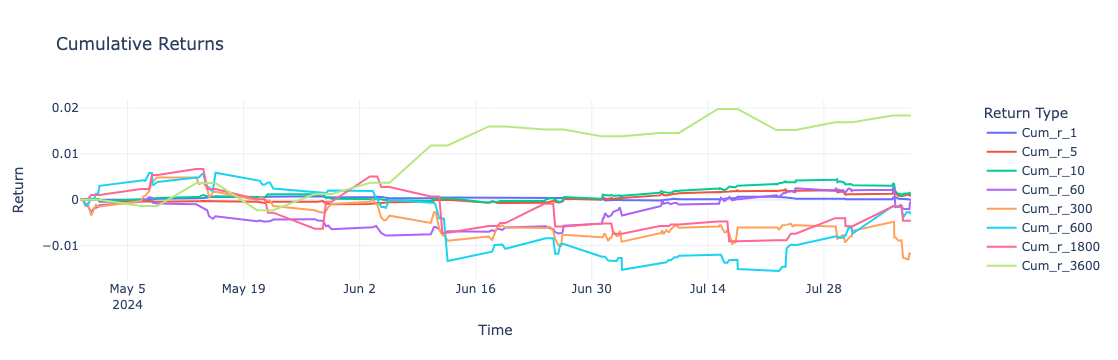


Performance Metrics for Cum_r_1:
Total Return: -0.0000
Max Drawdown: -0.0025
Sharpe Ratio: 9.1735

Performance Metrics for Cum_r_5:
Total Return: 0.0009
Max Drawdown: -0.0320
Sharpe Ratio: 4.3954

Performance Metrics for Cum_r_10:
Total Return: 0.0013
Max Drawdown: -0.0048
Sharpe Ratio: 6.9684

Performance Metrics for Cum_r_60:
Total Return: -0.0004
Max Drawdown: -0.3403
Sharpe Ratio: -6.9003

Performance Metrics for Cum_r_300:
Total Return: -0.0118
Max Drawdown: -0.6036
Sharpe Ratio: -8.5133

Performance Metrics for Cum_r_600:
Total Return: -0.0031
Max Drawdown: -0.6992
Sharpe Ratio: -6.9755

Performance Metrics for Cum_r_1800:
Total Return: -0.0046
Max Drawdown: -0.4765
Sharpe Ratio: -6.6103

Performance Metrics for Cum_r_3600:
Total Return: 0.0184
Max Drawdown: -0.0159
Sharpe Ratio: 8.8524

Additional Performance Metrics for r_1_v:
Win Ratio: 0.2289
P&L Ratio: 0.9211
Risk Return Ratio: 0.2734

Additional Performance Metrics for r_5_v:
Win Ratio: 0.3916
P&L Ratio: 0.8408
Risk Return

In [6]:
def calculate_metrics(returns):
    total_return = returns.iloc[-1]
    daily_returns = (1 + returns).resample('D').prod() - 1
    
    # Calculate max drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calculate Sharpe ratio (assuming risk-free rate of 0)
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    
    return {
        'Total Return': total_return,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio
    }

def calculate_additional_metrics(df, column):
    positive_returns = df[df[column] > 0][column]
    negative_returns = df[df[column] < 0][column]
    
    win_ratio = len(positive_returns) / len(df[column])
    pnl_ratio = positive_returns.mean() / abs(negative_returns.mean()) if len(negative_returns) > 0 else np.inf
    risk_return_ratio = (win_ratio / (1 - win_ratio)) * pnl_ratio if win_ratio < 1 else np.inf
    
    return {
        'Win Ratio': win_ratio,
        'P&L Ratio': pnl_ratio,
        'Risk Return Ratio': risk_return_ratio
    }

def plot_returns_and_metrics(df):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces for each return series
    for col in [f'Cum_r_{n}' for n in time_intervals]:
        fig.add_trace(
            go.Scatter(x=df['createDate'], y=df[col], name=col),
            secondary_y=False,
        )

    # Update layout
    fig.update_layout(
        title='Cumulative Returns',
        xaxis_title='Time',
        yaxis_title='Return',
        legend_title='Return Type',
        hovermode="x unified",
        template="plotly_white",
    )

    # Show the plot
    fig.show()
    fig.write_html(f"result/{tag}_backtest_result.html")

    # Calculate and print metrics
    for col in [f'Cum_r_{n}' for n in time_intervals]:
        cum_metrics = calculate_metrics(df.set_index('createDate')[col])
        print(f"\nPerformance Metrics for {col}:")
        for metric, value in cum_metrics.items():
            print(f"{metric}: {value:.4f}")

    # Calculate and print additional metrics for r_n_v columns
    r_columns = [col for col in df.columns if col.startswith('r_') and col.endswith('_v')]
    for col in r_columns:
        add_metrics = calculate_additional_metrics(df, col)
        print(f"\nAdditional Performance Metrics for {col}:")
        for metric, value in add_metrics.items():
            print(f"{metric}: {value:.4f}")

df['createDate'] = pd.to_datetime(df['createDate'])
plot_returns_and_metrics(df)